In [67]:
import numpy as np
import math
import cv2
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.text as mtext

from skimage.measure import label, regionprops

%matplotlib inline

In [68]:
frame = np.load('../images/sample-1.npy')

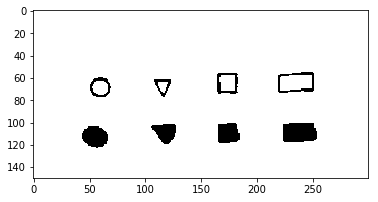

In [69]:
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)[0:150, 0:300]
threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1] / 255

plt.imshow(threshold, cmap='gray')

labeled 8 regions


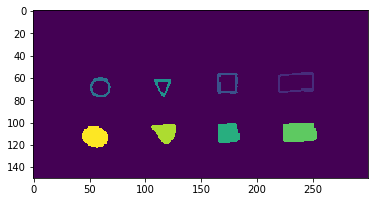

In [133]:
labeled_image = label(threshold[0:150, 0:300], background=1)
print 'labeled {} regions'.format(labeled_image.max())
plt.imshow(labeled_image, vmin=labeled_image.min(), vmax=labeled_image.max())

In [134]:
regions =  regionprops(labeled_image)

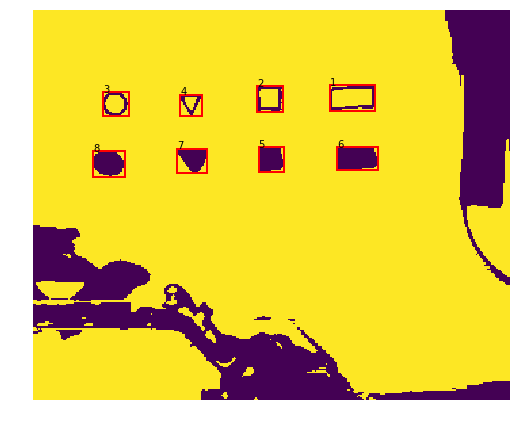

In [135]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(threshold)

for region in regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.annotate('{}'.format(region.label), (minc, minr))

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [136]:
LABELS = {
    1: 'rectangle_slot',
    2: 'square_slot',
    3: 'circle_slot',
    4: 'triangle_slot',
    5: 'square_block',
    6: 'rectangle_block',
    7: 'triangle_block',
    8: 'circle_block'
}

def parse_region(region):
    return {
        'area': region.area,
        'orientation': region.orientation,
        'perimeter': region.perimeter,
        'minor_axis': region.minor_axis_length,
        'major_axis': region.major_axis_length,
        'convex_area': region.convex_area,
        'filled_area': region.filled_area, 
        'solidity': region.solidity,
        'image': region.image
    }
    

region_stats = pd.DataFrame()
for r in regions:
    region = parse_region(r)
    region['label'] = LABELS[int(r.label)]
    region_stats = region_stats.append(region, ignore_index=True)

region_stats

,area,convex_area,filled_area,image,label,major_axis,minor_axis,orientation,perimeter,solidity
0,194.0,586.0,561.0,"[[False, False, False, False, False, False, Fa...",rectangle_slot,45.833759,26.666505,0.094125,163.692388,0.331058
1,153.0,355.0,339.0,"[[False, True, True, True, True, True, True, T...",square_slot,26.813371,25.947988,0.058304,116.142136,0.430986
2,122.0,276.0,270.0,"[[False, False, False, False, False, False, Fa...",circle_slot,23.313617,22.795519,0.528066,75.627417,0.442029
3,94.0,161.0,156.0,"[[True, True, True, True, True, True, True, Tr...",triangle_slot,18.884162,17.215186,-1.196367,78.763456,0.583851
4,306.0,317.0,306.0,"[[False, False, False, False, False, False, Fa...",square_block,20.758910,19.380223,0.155052,65.313708,0.965300
5,479.0,488.0,479.0,"[[False, False, False, False, False, True, Tru...",rectangle_block,33.307525,18.836044,0.028858,85.899495,0.981557
6,269.0,279.0,269.0,"[[False, False, False, False, False, False, Fa...",triangle_block,20.873894,17.945988,-0.406693,64.284271,0.964158
7,343.0,354.0,343.0,"[[False, False, False, False, False, True, Tru...",circle_block,23.596829,18.518534,-0.256290,67.698485,0.968927


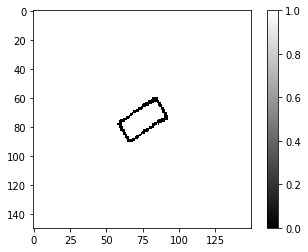

In [137]:
def rotate_scale_image(mat, angle, scale):
    height, width = mat.shape[:2]
    image_center = (width / 2, height / 2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)

    radians = math.radians(angle)
    sin = math.sin(radians)
    cos = math.cos(radians)
    bound_w = int((height * abs(sin)) + (width * abs(cos)))
    bound_h = int((height * abs(cos)) + (width * abs(sin)))

    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    scale += 1
    rotated_mat = cv2.resize(rotated_mat, (0,0), fx=scale, fy=scale) 
   
    horizontal_padding = (150 - rotated_mat.shape[0]) / 2
    vertical_padding = (150 - rotated_mat.shape[1])/2
        
    rotated_mat = cv2.copyMakeBorder(rotated_mat, horizontal_padding, horizontal_padding, vertical_padding, vertical_padding, cv2.BORDER_CONSTANT, value=0)
    rotated_mat = np.abs(1 - rotated_mat)

    return rotated_mat 
    
plt.imshow(rotate_scale_image(region_stats.iloc[0]['image'].astype(np.uint8), 30, -0.01), cmap='gray')
plt.colorbar()
plt.show()

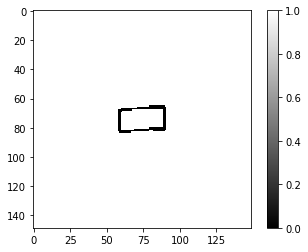

In [138]:
plt.imshow(rotate_scale_image(region_stats.iloc[0]['image'].astype(np.uint8), 0, -0.01), cmap='gray')
plt.colorbar()
plt.show()

# Randomize Rotation and Scale

In [139]:
training_set = pd.DataFrame()

def rotate_and_parse_region(image, angle, scale):
    image = rotate_scale_image(image, angle, scale)
    labels = label(image, background=1)
    region = regionprops(labels)
    if len(region) != 1:
        raise
    return parse_region(region[0])
    

for index, region in region_stats.iterrows():
    for angle in range(0, 180):
        angle *= 2
        scale = 0.05 - 0.025*np.random.rand()
        try:
            r = rotate_and_parse_region(region['image'].astype(np.uint8), angle, scale)
        except:
            continue
        r['label'] = region.label
        r['angle'] = angle
        r['scale'] = scale
        r.pop('image', None)
        
        training_set = training_set.append(r, ignore_index=True)


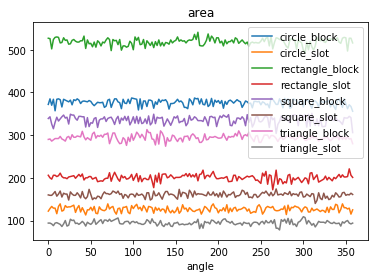

In [140]:
def plot_feature(feature):
    t = training_set.set_index('angle')
    t.groupby('label')[feature].plot(legend=True, title=feature)

plot_feature('area')

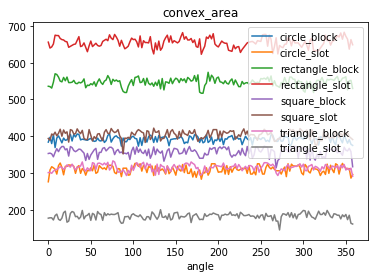

In [141]:
plot_feature('convex_area')

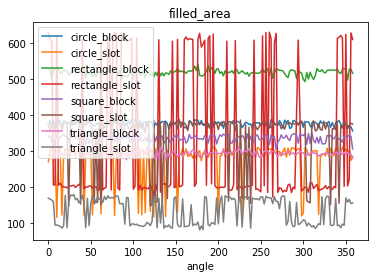

In [142]:
plot_feature('filled_area')

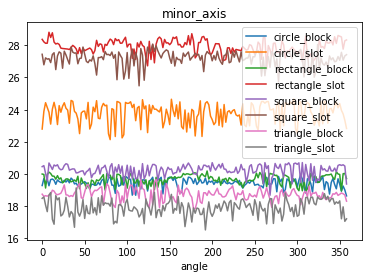

In [143]:
plot_feature('minor_axis')

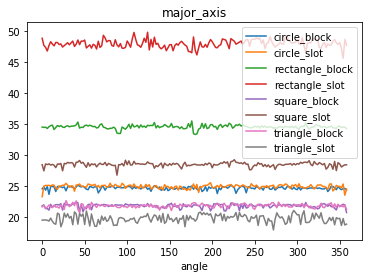

In [144]:
plot_feature('major_axis')

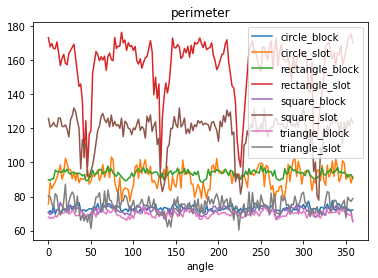

In [145]:
plot_feature('perimeter')

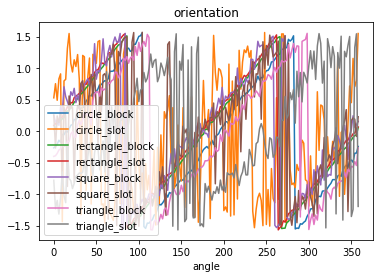

In [146]:
plot_feature('orientation')

# Classification

In [147]:
import sklearn.naive_bayes

model = sklearn.naive_bayes.GaussianNB()

INPUT_FEATURES = ['minor_axis', 'major_axis', 'area', 'solidity']

In [148]:
features = []
for feature_name in INPUT_FEATURES:
    features.append(training_set[feature_name])
    
features = np.array(features).transpose()

labels = np.array(training_set['label'])

In [149]:
model.fit(features, labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [150]:
print model.theta_
print model.sigma_

[[1.94512021e+01 2.46971104e+01 3.76294444e+02 9.59811775e-01]
 [2.37904343e+01 2.49493723e+01 1.26622222e+02 4.08993565e-01]
 [1.96739052e+01 3.45572507e+01 5.18488889e+02 9.47217677e-01]
 [2.79384531e+01 4.79361248e+01 2.00678788e+02 3.06314793e-01]
 [2.02416207e+01 2.18289720e+01 3.35661111e+02 9.39353736e-01]
 [2.72042214e+01 2.84909959e+01 1.60296089e+02 3.96407808e-01]
 [1.87419139e+01 2.18373270e+01 2.94105556e+02 9.34227619e-01]
 [1.79181896e+01 1.97831954e+01 9.47166667e+01 5.18241477e-01]]
[[7.35039836e-02 6.86308094e-02 5.35966542e+01 1.07712478e-04]
 [4.00089245e-01 1.01177043e-01 3.66461913e+01 1.48265452e-04]
 [8.64148615e-02 9.76905348e-02 7.12054505e+01 1.75131986e-04]
 [1.82328420e-01 4.27637845e-01 5.66544169e+01 1.19649986e-04]
 [1.24642744e-01 9.95677627e-02 8.18018394e+01 2.54880227e-04]
 [2.23759685e-01 1.17186723e-01 3.28900031e+01 1.46038142e-04]
 [1.26834050e-01 8.75013560e-02 4.57722098e+01 2.66059122e-04]
 [2.51756647e-01 4.07773903e-01 2.66475184e+01 5.25522

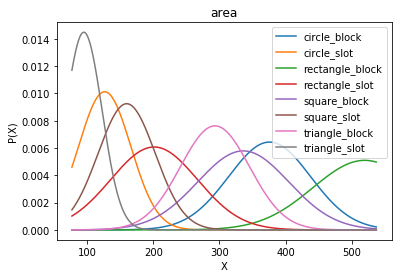

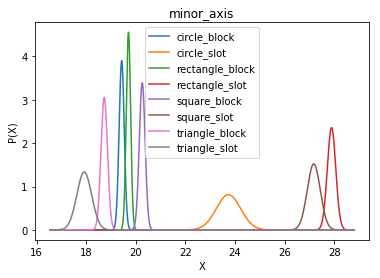

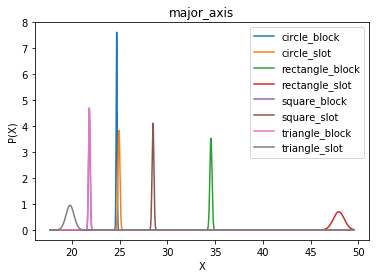

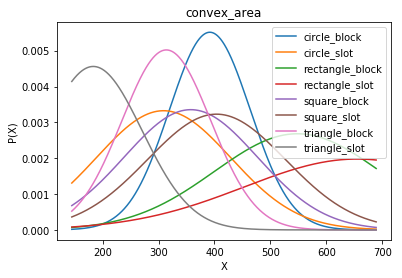

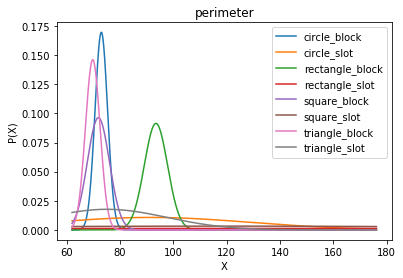

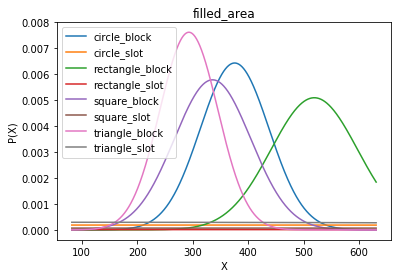

In [98]:
from scipy.stats import norm

for feature_index, feature_name in enumerate(INPUT_FEATURES):  
    x_range = np.arange(training_set[feature_name].min(), training_set[feature_name].max(), 0.001)
  
    for class_index, class_name in enumerate(model.classes_):
        ax = plt.plot(
            x_range, 
            norm.pdf(x_range, model.theta_[class_index][feature_index],model.sigma_[class_index][feature_index]),
            label=class_name
        )
    plt.title(feature_name)
    plt.xlabel('X')
    plt.ylabel('P(X)')
    plt.legend()
    plt.show()

In [99]:
model.class_prior_ 

array([0.12596221, 0.12596221, 0.12596221, 0.1196641 , 0.12596221,
       0.12526242, 0.12596221, 0.12526242])

In [100]:
model.predict_proba([])

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
samples = np.array([
    region_stats['area'],
    region_stats['minor_axis'],
    region_stats['major_axis'],
    region_stats['convex_area'],
    region_stats['perimeter'],
    region_stats['filled_area']
]).transpose()
model.predict_proba(samples)

# Inference

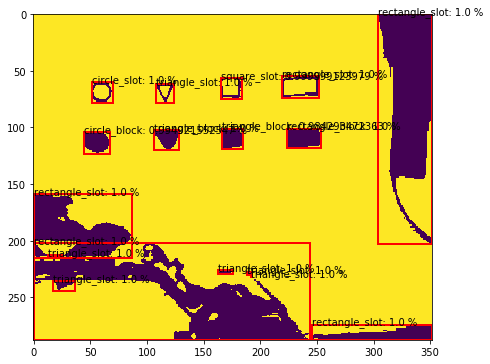

In [151]:
frame = np.load('../images/sample-1.npy')
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1] / 255
labeled_image = label(threshold, background=1)
regions =  regionprops(labeled_image)
region_stats = pd.DataFrame()
for r in regions:
    region = parse_region(r)
    region_stats = region_stats.append(region, ignore_index=True)

region_stats

features = []
for feature_name in INPUT_FEATURES:
    features.append(region_stats[feature_name])
    
features = np.array(features).transpose()
predictions = model.predict_proba(features)


fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(threshold)

p = []

for index, prediction in enumerate(predictions):
    minr, minc, maxr, maxc = regions[index].bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    p.append([model.classes_[prediction.argmax()], prediction.max()])
    ax.annotate('{}: {} %'.format(model.classes_[prediction.argmax()], prediction.max()), (minc, minr))
    
plt.show()


In [152]:
p

[['rectangle_slot', 1.0],
 ['rectangle_slot', 1.0],
 ['square_slot', 0.9999991239788493],
 ['circle_slot', 1.0],
 ['triangle_slot', 1.0],
 ['triangle_block', 0.9842934723633411],
 ['rectangle_block', 1.0],
 ['triangle_block', 1.0],
 ['circle_block', 0.9949215525468857],
 ['rectangle_slot', 1.0],
 ['rectangle_slot', 1.0],
 ['triangle_slot', 1.0],
 ['triangle_slot', 1.0],
 ['triangle_slot', 1.0],
 ['triangle_slot', 1.0],
 ['triangle_slot', 1.0],
 ['rectangle_slot', 1.0]]

In [ ]:
predictions